# Genome and Annotations Download

In [2]:
!mkdir genome
%cd genome
!wget -nc -O genome.fa.gz https://ftp.ebi.ac.uk/pub/databases/wormbase/parasite/releases/WBPS19/species/schistosoma_mansoni/PRJEA36577/schistosoma_mansoni.PRJEA36577.WBPS19.genomic.fa.gz
!gzip -d -f genome.fa.gz

/data/users/willetse0745/sm_mira_ivt/Sm_Mira_IvT/genome/genome
--2024-11-21 16:41:34--  https://ftp.ebi.ac.uk/pub/databases/wormbase/parasite/releases/WBPS19/species/schistosoma_mansoni/PRJEA36577/schistosoma_mansoni.PRJEA36577.WBPS19.genomic.fa.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116797085 (111M) [application/x-gzip]
Saving to: ‘genome.fa.gz’

genome.fa.gz        100%[===================>] 111.39M  27.9MB/s    in 4.9s    

2024-11-21 16:41:40 (22.9 MB/s) - ‘genome.fa.gz’ saved [116797085/116797085]



In [3]:
!wget -O - https://ftp.ebi.ac.uk/pub/databases/wormbase/parasite/releases/WBPS19/species/schistosoma_mansoni/PRJEA36577/schistosoma_mansoni.PRJEA36577.WBPS19.canonical_geneset.gtf.gz | \
    gzip -f -d > annotations.gtf

--2024-11-21 16:17:57--  https://ftp.ebi.ac.uk/pub/databases/wormbase/parasite/releases/WBPS19/species/schistosoma_mansoni/PRJEA36577/schistosoma_mansoni.PRJEA36577.WBPS19.canonical_geneset.gtf.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3228084 (3.1M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>]   3.08M  3.73MB/s    in 0.8s    

2024-11-21 16:17:58 (3.73 MB/s) - written to stdout [3228084/3228084]



### JBrowse Visualization

In [4]:
!grep 'Smp_317470.1' annotations.gtf | cut -f 3 | grep 'exon' | uniq -c

      5 exon


In [5]:
!samtools faidx genome.fa

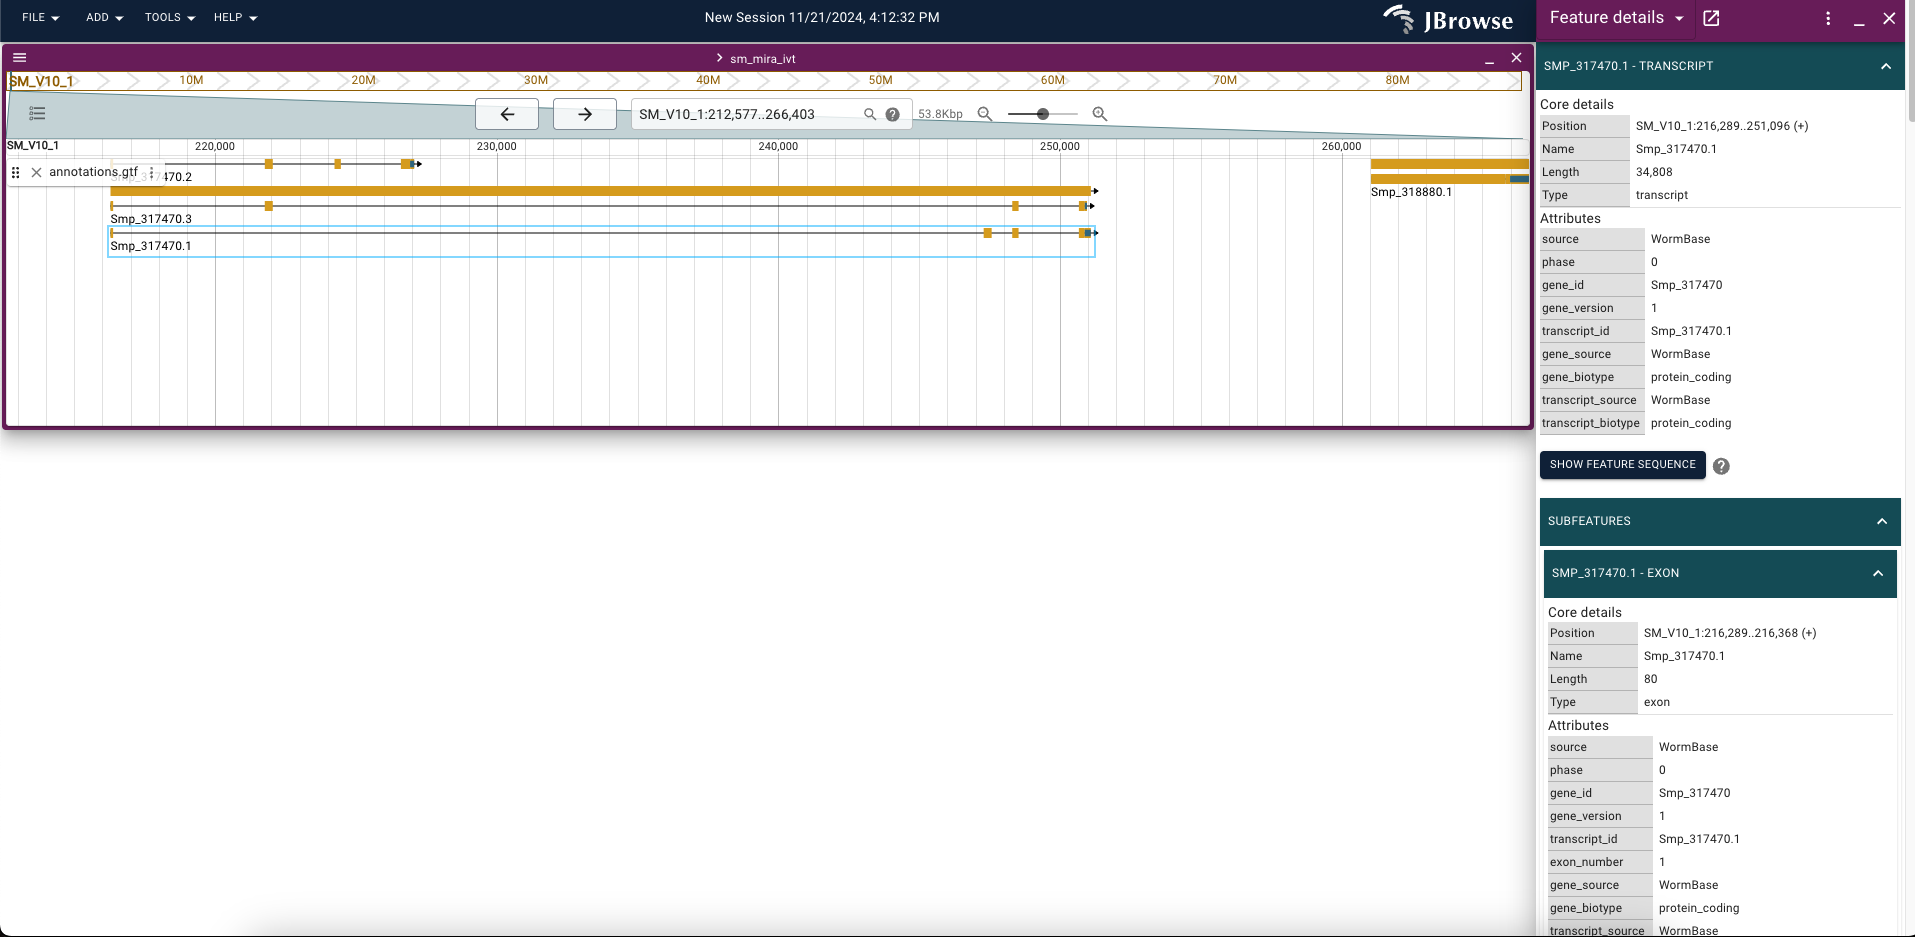

Viewing specific gene in the genome (Smp_317470.1). It contains 5 exons (indicated by the yellow bars.)

# FASTQs + QC Prior to Trimming

In [7]:
!mkdir fastq_sm_mira
!mkdir fastq_sm_mira/qc
!fastqc -t 32 /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/*.fastq.gz -o fastq_sm_mira/qc

mkdir: cannot create directory ‘fastq_sm_mira’: File exists
mkdir: cannot create directory ‘fastq_sm_mira/qc’: File exists
application/gzip
application/gzip
Started analysis of Int-01_S42_L005_R1_001.fastq.gz
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
Started analysis of Int-01_S42_L005_R2_001.fastq.gz
Started analysis of Int-02_S43_L005_R1_001.fastq.gz
Started analysis of Int-02_S43_L005_R2_001.fastq.gz
Started analysis of Int-03_S44_L005_R1_001.fastq.gz
Started analysis of Int-03_S44_L005_R2_001.fastq.gz
Started analysis of Int-04_S45_L005_R1_001.fastq.gz
Started analysis of Int-04_S45_L005_R2_001.fastq.gz
Started analysis of Liv-01_S38_L005_R1_001.fastq.gz
Started analysis of Liv-01_S38_L005_R2_001.fastq.gz
Approx 5% complete for Int-01_S42_L005_R1_001.fastq.gz
Started analysis of Liv-02_S39

Utilize multiqc to visualize initial QC

In [1]:
!multiqc fastq_sm_mira/.


/// ]8;id=367735;https://multiqc.info\MultiQC]8;;\ 🔍 v1.25.2

       file_search | Search path: /data/users/willetse0745/sm_mira_ivt/Sm_Mira_IvT/fastq_sm_mira
         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 32/32  lm  
            fastqc | Found 16 reports
     write_results | Data        : multiqc_data
     write_results | Report      : multiqc_report.html
           multiqc | MultiQC complete


### QC Evaluations

*Per base sequence quality*: 16/16 passed!

*Per tile sequence quality*: 16/16 failed. 

*Per sequence quality scores*: 16/16 passed!

*Per base sequence content*: 4/16 failed, 12 orange. All of the errors appear to be within the first 20 bp. Assume this to be barcodes, adaptors, or UMIs/UMI linkers. This will be addressed in trimming.

*Per sequence GC content*: 15/16 failed, 1 orange. Distribution appears to all be relatively normal - nothing too concerning (sharp peaks or abnormalities).

*Per base N content*: 16/16 passed! 

*Sequence length distribution*: 16/16 passed!

*Sequence duplication levels*: 16/16 failed. Appear to be below 30% duplication for all samples. May be related to adaptors that are found in the samples. 

*Overrepresented sequences*: 11/16 failed, 5 orange. Same as sequence duplication levels reasoning. However, for the top overrepresented sequence, it was 50 G's repeated. This occurred almost 4 million times in over 1.5% of the reads. Not sure if this is a barcode? The other sequences weren't of concern. 

*Adapter content*: 16/16 failed. Universal Illumina adapters, poly-a, and poly-g were listed. This will be addressed in the trimming.

# FASTQ Trimming + Filtering

In [2]:
%mkdir trimmed_mira
!cutadapt -j 32 -m 20 -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCA -A AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT -o trimmed_mira/Int-01_S42_L005_R1_001.fastq.gz -p trimmed_mira/Int-01_S42_L005_R2_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Int-01_S42_L005_R1_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Int-01_S42_L005_R2_001.fastq.gz
!cutadapt -j 32 -m 20 -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCA -A AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT -o trimmed_mira/Int-02_S43_L005_R1_001.fastq.gz -p trimmed_mira/Int-02_S43_L005_R2_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Int-02_S43_L005_R1_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Int-02_S43_L005_R2_001.fastq.gz
!cutadapt -j 32 -m 20 -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCA -A AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT -o trimmed_mira/Int-03_S44_L005_R1_001.fastq.gz -p trimmed_mira/Int-03_S44_L005_R2_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Int-03_S44_L005_R1_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Int-03_S44_L005_R2_001.fastq.gz
!cutadapt -j 32 -m 20 -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCA -A AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT -o trimmed_mira/Int-04_S45_L005_R1_001.fastq.gz -p trimmed_mira/Int-04_S45_L005_R2_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Int-04_S45_L005_R1_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Int-04_S45_L005_R2_001.fastq.gz
!cutadapt -j 32 -m 20 -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCA -A AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT -o trimmed_mira/Liv-01_S38_L005_R1_001.fastq.gz -p trimmed_mira/Liv-01_S38_L005_R2_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Liv-01_S38_L005_R1_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Liv-01_S38_L005_R2_001.fastq.gz
!cutadapt -j 32 -m 20 -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCA -A AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT -o trimmed_mira/Liv-02_S39_L005_R1_001.fastq.gz -p trimmed_mira/Liv-02_S39_L005_R2_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Liv-02_S39_L005_R1_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Liv-02_S39_L005_R2_001.fastq.gz
!cutadapt -j 32 -m 20 -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCA -A AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT -o trimmed_mira/Liv-03_S40_L005_R1_001.fastq.gz -p trimmed_mira/Liv-03_S40_L005_R2_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Liv-03_S40_L005_R1_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Liv-03_S40_L005_R2_001.fastq.gz
!cutadapt -j 32 -m 20 -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCA -A AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT -o trimmed_mira/Liv-04_S41_L005_R1_001.fastq.gz -p trimmed_mira/Liv-04_S41_L005_R2_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Liv-04_S41_L005_R1_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Liv-04_S41_L005_R2_001.fastq.gz

This is cutadapt 4.9 with Python 3.9.20
Command line parameters: -j 32 -m 20 -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCA -A AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT -o trimmed_mira/Int-01_S42_L005_R1_001.fastq.gz -p trimmed_mira/Int-01_S42_L005_R2_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Int-01_S42_L005_R1_001.fastq.gz /data/classes/2024/fall/biol343/course_files/20240923_LH00283_0144_B22NMVKLT3/subsample/Int-01_S42_L005_R2_001.fastq.gz
Processing paired-end reads on 32 cores ...
Done           00:00:19    12,421,987 reads @   1.6 µs/read;  38.33 M reads/minute
Finished in 19.661 s (1.583 µs/read; 37.91 M reads/minute).

=== Summary ===

Total read pairs processed:         12,421,987
  Read 1 with adapter:               3,497,158 (28.2%)
  Read 2 with adapter:               3,222,254 (25.9%)

== Read fate breakdown ==
Pairs that were too short:             221,073 (1.8%)
Pairs written (passing filters):    12,200,914 (98.2%)

Total basepair

In [4]:
!mkdir trimmed_mira/qc
!fastqc -t 32 trimmed_mira/*.fastq.gz -o trimmed_mira/qc
!multiqc --force -d fastq_sm_mira/qc/ trimmed_mira/qc/

application/gzip
application/gzip
Started analysis of Int-01_S42_L005_R1_001.fastq.gz
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
Started analysis of Int-01_S42_L005_R2_001.fastq.gz
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
Started analysis of Int-02_S43_L005_R1_001.fastq.gz
application/gzip
Started analysis of Int-02_S43_L005_R2_001.fastq.gz
Started analysis of Int-03_S44_L005_R1_001.fastq.gz
Started analysis of Int-03_S44_L005_R2_001.fastq.gz
Started analysis of Int-04_S45_L005_R1_001.fastq.gz
Started analysis of Int-04_S45_L005_R2_001.fastq.gz
Started analysis of Liv-01_S38_L005_R1_001.fastq.gz
Started analysis of Liv-01_S38_L005_R2_001.fastq.gz
Started analysis of Liv-02_S39_L005_R1_001.fastq.gz
Started analysis of Liv-02_S39_L005_R2_001.fastq.gz
Approx 5% complete for Int-01_S42_L005_R1_001.fastq.gz
Started analysis of Liv-03_S40_L005_R1_001.fastq.

### QC Evaluations Post-Trimming

*Per base sequence quality*: 16/16 passed!

*Per tile sequence quality*: 16/16 failed.

*Per sequence quality scores*: 16/16 passed!

*Per base sequence content*: 6/16 orange, 10 failed. May not have fully trimmed all of the barcodes?

*Per sequence GC content*: 2/16 orange, 14 failed. Same reasoning as above.

*Per base N content*: 16/16 passed!

*Sequence length distribution*: 16/16 orange. This is because the sequence length has gone down after trimming. This isn't a concern.

*Sequence duplication levels*: 16/16 failed.

*Overrepresented sequences*: 4/16 passed! 1/16 failed, 11 orange. Having some passing is a good sign that adapters were removed from trimming.

*Adapter content*: 16/16 passed! Went from 16/16 failed prior to trimming to all passing! This was solved due to removing the adapter sequences in trimming.

# Aligning RNA-seq Reads to Reference Genome

## Utilizing STAR

#### Basic Alignment

In [3]:
%mkdir alignment_mira/star/

!STAR \
--runThreadN 16 \
--runMode genomeGenerate \
--genomeDir ../Sm_Mira_IvT/genome/star \
--genomeFastaFiles ../Sm_Mira_IvT/genome/genome.fa \
--sjdbGTFfile ../Sm_Mira_IvT/genome/annotations.gtf \
--sjdbOverhang 150 \
--genomeSAindexNbases 13

	STAR --runThreadN 16 --runMode genomeGenerate --genomeDir ../Sm_Mira_IvT/genome/star --genomeFastaFiles ../Sm_Mira_IvT/genome/genome.fa --sjdbGTFfile ../Sm_Mira_IvT/genome/annotations.gtf --sjdbOverhang 150 --genomeSAindexNbases 13
	STAR version: 2.7.10a   compiled: 2022-01-14T18:50:00-05:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Dec 14 00:11:20 ..... started STAR run
Dec 14 00:11:20 ... starting to generate Genome files
Dec 14 00:11:26 ..... processing annotations GTF
Dec 14 00:11:33 ... starting to sort Suffix Array. This may take a long time...
Dec 14 00:11:35 ... sorting Suffix Array chunks and saving them to disk...
Dec 14 00:12:29 ... loading chunks from disk, packing SA...
Dec 14 00:12:41 ... finished generating suffix array
Dec 14 00:12:41 ... generating Suffix Array index
Dec 14 00:13:18 ... completed Suffix Array index
Dec 14 00:13:20 ..... inserting junctions into the genome indices
Dec 14 00:14:00 ... writing Genome to disk ...
Dec 14 00:14:03 ... writing Suffi

#### 2-Pass Alignment

In [3]:
!STAR \
--runThreadN 16 \
--runMode alignReads \
--genomeDir ../Sm_Mira_IvT/genome/star \
--readFilesManifest manifest_mira.tsv \
--readFilesCommand zcat \
--outSAMtype BAM SortedByCoordinate \
--outSAMunmapped Within \
--outFileNamePrefix alignment_mira/star/first_pass/

!cp alignment_mira/star/Log.final.out alignment_mira/star/first_pass/first-pass.final.out

	STAR --runThreadN 16 --runMode alignReads --genomeDir ../Sm_Mira_IvT/genome/star --readFilesManifest manifest_mira.tsv --readFilesCommand zcat --outSAMtype BAM SortedByCoordinate --outSAMunmapped Within --outFileNamePrefix alignment_mira/star/first_pass/
	STAR version: 2.7.10a   compiled: 2022-01-14T18:50:00-05:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Dec 17 18:09:21 ..... started STAR run
Dec 17 18:09:22 ..... loading genome
Dec 17 18:09:23 ..... started mapping
Dec 18 00:13:22 ..... finished mapping
Dec 18 00:13:22 ..... started sorting BAM
Dec 18 00:26:44 ..... finished successfully


In [4]:
!STAR \
--runThreadN 16 \
--runMode alignReads \
--genomeDir ../Sm_Mira_IvT/genome/star \
--readFilesManifest manifest_mira.tsv \
--readFilesCommand zcat \
--outSAMtype BAM SortedByCoordinate \
--outSAMunmapped Within \
--outSAMattributes NH HI AS nM RG \
--outFileNamePrefix alignment_mira/star/second_pass/ \
--sjdbFileChrStartEnd alignment_mira/star/SJ.out.tab

!cp alignment_mira/star/Log.final.out alignment_mira/star/second_pass/second-pass.final.out

	STAR --runThreadN 16 --runMode alignReads --genomeDir ../Sm_Mira_IvT/genome/star --readFilesManifest manifest_mira.tsv --readFilesCommand zcat --outSAMtype BAM SortedByCoordinate --outSAMunmapped Within --outSAMattributes NH HI AS nM RG --outFileNamePrefix alignment_mira/star/second_pass/ --sjdbFileChrStartEnd alignment_mira/star/SJ.out.tab
	STAR version: 2.7.10a   compiled: 2022-01-14T18:50:00-05:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Dec 18 00:26:50 ..... started STAR run
Dec 18 00:27:01 ..... loading genome
Dec 18 00:27:03 ..... inserting junctions into the genome indices
Dec 18 00:27:30 ..... started mapping
Dec 18 06:49:45 ..... finished mapping
Dec 18 06:49:46 ..... started sorting BAM
Dec 18 07:03:01 ..... finished successfully


# Alignment QC

### Samtools

In [5]:
!echo "STAR index"
!samtools index -@ 32 ../Sm_Mira_IvT/alignment_mira/star/second_pass/Aligned.sortedByCoord.out.bam
!echo "STAR mapping stats"
!samtools stats -@ 32 ../Sm_Mira_IvT/alignment_mira/star/second_pass/Aligned.sortedByCoord.out.bam > star_stats.txt

STAR index
STAR mapping stats


### Qualimap

In [6]:
!picard AddOrReplaceReadGroups I=alignment_mira/star/second_pass/Aligned.sortedByCoord.out.bam O=qualimap/output.bam RGLB=temp RGPL=Illumina RGPU=1 RGSM=20 VALIDATION_STRINGENCY=LENIENT

!qualimap bamqc -nt 32 -outdir qualimap/star/bam -bam alignment_mira/star/second_pass/Aligned.sortedByCoord.out.bam --feature-file genome/annotations.gtf
!qualimap rnaseq -outdir qualimap/star/rnaseq -bam alignment_mira/star/second_pass/Aligned.sortedByCoord.out.bam -gtf genome/annotations.gtf

INFO	2024-12-20 11:37:52	AddOrReplaceReadGroups	

********** NOTE: Picard's command line syntax is changing.
**********
********** For more information, please see:
********** https://github.com/broadinstitute/picard/wiki/Command-Line-Syntax-Transition-For-Users-(Pre-Transition)
**********
********** The command line looks like this in the new syntax:
**********
**********    AddOrReplaceReadGroups -I alignment_mira/star/second_pass/Aligned.sortedByCoord.out.bam -O qualimap/output.bam -RGLB temp -RGPL Illumina -RGPU 1 -RGSM 20 -VALIDATION_STRINGENCY LENIENT
**********


11:37:52.762 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/data/users/willetse0745/.conda/envs/sm_mira_ivt/share/picard-2.18.29-0/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Fri Dec 20 11:37:52 CST 2024] AddOrReplaceReadGroups INPUT=alignment_mira/star/second_pass/Aligned.sortedByCoord.out.bam OUTPUT=qualimap/output.bam RGLB=temp RGPL=Illumina RGPU=1 RGSM=20 VALIDATION_STRINGENCY=L

# Generating Counts from Alignment

### Picard Tools

In [1]:
%mkdir counting_mira
%mkdir counting_mira/logs/
%mkdir counting_mira/dedup/

!picard MarkDuplicates I=alignment_mira/star/second_pass/Aligned.sortedByCoord.out.bam M=counting_mira/logs/star_duplicates O=counting_mira/dedup/star.bam VALIDATION_STRINGENCY=SILENT

mkdir: cannot create directory ‘counting_mira’: File exists
mkdir: cannot create directory ‘counting_mira/logs/’: File exists
mkdir: cannot create directory ‘counting_mira/dedup/’: File exists
INFO	2024-12-20 13:05:56	MarkDuplicates	

********** NOTE: Picard's command line syntax is changing.
**********
********** For more information, please see:
********** https://github.com/broadinstitute/picard/wiki/Command-Line-Syntax-Transition-For-Users-(Pre-Transition)
**********
********** The command line looks like this in the new syntax:
**********
**********    MarkDuplicates -I alignment_mira/star/second_pass/Aligned.sortedByCoord.out.bam -M counting_mira/logs/star_duplicates -O counting_mira/dedup/star.bam -VALIDATION_STRINGENCY SILENT
**********


13:05:56.698 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/data/users/willetse0745/.conda/envs/sm_mira_ivt/share/picard-2.18.29-0/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Fri Dec 20 13:05:56 CST 2024] 

### Feature Counts

In [2]:
!featureCounts -T 32 \
    counting_mira/dedup/star.bam \
    -T 32 \
    -p \
    --byReadGroup \
    -s 1 \
    --ignoreDup \
    -M \
    --fraction \
    -a ../Sm_Mira_IvT/genome/annotations.gtf \
    -o counting_mira/star_counts.tsv \
    --verbose


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.6

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                                                                            ||
||                           star.bam                                         ||
||                                                                            ||
||             Output file : star_counts.tsv                     

### MultiQC Report

In [3]:
!multiqc --force -d . -n reports/multiqc_report.html


  /// ]8;id=377993;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.19

|           multiqc | MultiQC Version v1.25.2 now available!
|           multiqc | Prepending directory to sample names
|           multiqc | Search path : /data/users/willetse0745/sm_mira_ivt/Sm_Mira_IvT
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 251/251   ./reports/multiqc_report.html
|          qualimap | Found 1 BamQC reports
|          qualimap | Found 1 RNASeq reports
|    feature_counts | Found 1 reports
|            picard | Found 1 MarkDuplicates reports
|          samtools | Found 1 stats reports
|              star | Found 3 reports
|            fastqc | Found 32 reports
|           multiqc | Report      : reports/multiqc_report.html   (overwritten)
|           multiqc | Data        : reports/multiqc_report_data   (overwritten)
|           multiqc | MultiQC complete


## Differential Expression Utilizing R

In [11]:
!Rscript differential_exp.R

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning messages:
1: package ‘tidyverse’ was built under R version 4.2.3 
2: package ‘ggplot2’ was built under R version 4.2.3 
3: package ‘tibble’ was built under R version 4.2.3 
4: package ‘tidyr’ was built under R version 4.2.3 
5: package ‘readr’ was built under R version 4.2.3 
6: package ‘purrr’ was built under R version 4.2.3 
7: package ‘dplyr’ was built under R version 4.2.3 
8: package ‘stringr’ was built under R version 4.2.3 
9: package ‘forcats’ was built un

R figured to work on BIOL343 environment...not working on this env due to settings that were changed